In [26]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load the dataset
url = "https://raw.githubusercontent.com/softwareWCU/Data-Preprocessing-for-ML-using-Titanic-Dataset/main/titanic2.csv"
df = pd.read_csv(url)

print("=== INITIAL DATA EXPLORATION ===")
print(f"Dataset shape: {df.shape}")
print("\nData types and info:")
df.info()
print("\nFirst 5 rows:")
display(df.head())

=== INITIAL DATA EXPLORATION ===
Dataset shape: (909, 12)

Data types and info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 909 entries, 0 to 908
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  909 non-null    int64  
 1   Survived     909 non-null    int64  
 2   Pclass       909 non-null    object 
 3   Name         909 non-null    object 
 4   Sex          909 non-null    object 
 5   Age          710 non-null    float64
 6   SibSp        909 non-null    int64  
 7   Parch        909 non-null    int64  
 8   Ticket       909 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        208 non-null    object 
 11  Embarked     907 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 85.3+ KB

First 5 rows:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",Female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [27]:
# Enhanced Data Quality Assessment
print("=== DATA QUALITY ASSESSMENT ===")

# Check for missing values
missing_count = df.isnull().sum()
missing_pct = (df.isnull().mean() * 100).round(2)
missing_df = pd.DataFrame({"missing_count": missing_count, "missing_pct": missing_pct})
missing_df = missing_df[missing_df['missing_count'] > 0].sort_values("missing_pct", ascending=False)
print("Missing values summary:")
display(missing_df)

# Check for duplicates
print(f"\nNumber of duplicate rows: {df.duplicated().sum()}")

# Check data types
print("\nData types:")
print(df.dtypes)

# Basic statistics for numerical columns
print("\nBasic statistics for numerical columns:")
display(df.describe())

=== DATA QUALITY ASSESSMENT ===
Missing values summary:


,missing_count,missing_pct
Cabin,701,77.12
Age,199,21.89
Fare,18,1.98
Embarked,2,0.22



Number of duplicate rows: 10

Data types:
PassengerId      int64
Survived         int64
Pclass          object
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Basic statistics for numerical columns:


,PassengerId,Survived,Age,SibSp,Parch,Fare
count,909.000000,909.000000,710.000000,909.000000,909.000000,891.000000
mean,446.040704,0.387239,29.603169,0.522552,0.380638,31.431149
std,257.212740,0.487387,14.566894,1.098050,0.802185,46.797866
min,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000
25%,224.000000,0.000000,20.000000,0.000000,0.000000,7.895800
50%,445.000000,0.000000,28.000000,0.000000,0.000000,14.454200
75%,669.000000,1.000000,38.000000,1.000000,0.000000,30.847900
max,891.000000,1.000000,80.000000,8.000000,6.000000,512.329200


In [28]:
# Data Cleaning and Preprocessing

def clean_titanic_data(df):
    """
    Comprehensive data cleaning function for Titanic dataset
    """
    df_clean = df.copy()

    print("=== STARTING DATA CLEANING ===")

    # 1. Handle data type conversions
    print("1. Converting data types...")
    df_clean['Age'] = pd.to_numeric(df_clean['Age'], errors='coerce')
    df_clean['Fare'] = pd.to_numeric(df_clean['Fare'], errors='coerce')
    df_clean['Pclass'] = pd.to_numeric(df_clean['Pclass'], errors='coerce')

    # 2. Handle missing values
    print("2. Handling missing values...")

    # Drop rows where essential columns are missing
    initial_rows = len(df_clean)
    df_clean = df_clean.dropna(subset=['Pclass', 'Embarked'])
    print(f"   Dropped {initial_rows - len(df_clean)} rows with missing Pclass/Embarked")

    # Age: Fill with median grouped by Pclass and Sex
    age_medians = df_clean.groupby(['Pclass', 'Sex'])['Age'].median()
    def fill_age(row):
        if pd.isnull(row['Age']):
            return age_medians[row['Pclass']][row['Sex']]
        return row['Age']

    df_clean['Age'] = df_clean.apply(fill_age, axis=1)
    print("   Filled missing Age values with median by Pclass and Sex")

    # Fare: Fill with median grouped by Pclass
    fare_medians = df_clean.groupby('Pclass')['Fare'].median()
    df_clean['Fare'] = df_clean.apply(
        lambda row: fare_medians[row['Pclass']] if pd.isnull(row['Fare']) else row['Fare'],
        axis=1
    )
    print("   Filled missing Fare values with median by Pclass")

    # Cabin: Create new feature indicating whether cabin info is available
    df_clean['Has_Cabin'] = df_clean['Cabin'].notnull().astype(int)
    df_clean = df_clean.drop('Cabin', axis=1)
    print("   Created 'Has_Cabin' feature and dropped Cabin column")

    # 3. Handle inconsistent categorical values
    print("3. Standardizing categorical values...")
    df_clean['Sex'] = df_clean['Sex'].astype(str).str.lower().str.strip()
    df_clean['Embarked'] = df_clean['Embarked'].astype(str).str.upper().str.strip()

    # Fix common inconsistencies in Embarked
    embarked_mapping = {'CHERBOURG': 'C', 'SOUTHAMPTON': 'S'}
    df_clean['Embarked'] = df_clean['Embarked'].replace(embarked_mapping)

    print(f"   Unique values in Sex: {df_clean['Sex'].unique()}")
    print(f"   Unique values in Embarked: {df_clean['Embarked'].unique()}")

    # 4. Remove duplicates
    print("4. Removing duplicates...")
    initial_rows = len(df_clean)
    df_clean = df_clean.drop_duplicates()
    print(f"   Removed {initial_rows - len(df_clean)} duplicate rows")

    # 5. Feature Engineering
    print("5. Creating new features...")

    # Family size
    df_clean['FamilySize'] = df_clean['SibSp'] + df_clean['Parch'] + 1

    # Is alone
    df_clean['IsAlone'] = (df_clean['FamilySize'] == 1).astype(int)

    # Title from Name
    df_clean['Title'] = df_clean['Name'].str.extract(' ([A-Za-z]+)\\.', expand=False)
    title_mapping = {
        'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master',
        'Dr': 'Rare', 'Rev': 'Rare', 'Col': 'Rare', 'Major': 'Rare',
        'Mlle': 'Miss', 'Ms': 'Miss', 'Lady': 'Rare', 'Countess': 'Rare',
        'Capt': 'Rare', 'Sir': 'Rare', 'Don': 'Rare', 'Dona': 'Rare',
        'Mme': 'Mrs', 'Jonkheer': 'Rare'
    }
    df_clean['Title'] = df_clean['Title'].map(title_mapping)
    df_clean['Title'] = df_clean['Title'].fillna('Rare')

    # Age groups
    df_clean['AgeGroup'] = pd.cut(df_clean['Age'],
                                 bins=[0, 12, 18, 35, 60, 100],
                                 labels=['Child', 'Teen', 'Adult', 'Middle', 'Senior'])

    # Fare groups
    df_clean['FareGroup'] = pd.qcut(df_clean['Fare'], 4,
                                   labels=['Low', 'Medium', 'High', 'Very High'])

    # 6. Handle outliers using IQR method (more robust approach)
    print("6. Handling outliers...")

    def handle_outliers_iqr(df, column):
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Cap outliers instead of removing rows
        df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
        df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
        return df

    df_clean = handle_outliers_iqr(df_clean, 'Age')
    df_clean = handle_outliers_iqr(df_clean, 'Fare')
    print("   Capped outliers in Age and Fare using IQR method")

    # 7. Drop unnecessary columns
    print("7. Dropping unnecessary columns...")
    columns_to_drop = ['PassengerId', 'Name', 'Ticket']
    df_clean = df_clean.drop([col for col in columns_to_drop if col in df_clean.columns], axis=1)
    print(f"   Dropped columns: {columns_to_drop}")

    print(f"\nFinal dataset shape: {df_clean.shape}")
    print("Missing values after cleaning:")
    print(df_clean.isnull().sum())

    return df_clean

# Apply cleaning function
df_cleaned = clean_titanic_data(df)

=== STARTING DATA CLEANING ===
1. Converting data types...
2. Handling missing values...
   Dropped 20 rows with missing Pclass/Embarked
   Filled missing Age values with median by Pclass and Sex
   Filled missing Fare values with median by Pclass
   Created 'Has_Cabin' feature and dropped Cabin column
3. Standardizing categorical values...
   Unique values in Sex: ['male' 'female']
   Unique values in Embarked: ['S' 'C' 'Q']
4. Removing duplicates...
   Removed 12 duplicate rows
5. Creating new features...
6. Handling outliers...
   Capped outliers in Age and Fare using IQR method
7. Dropping unnecessary columns...
   Dropped columns: ['PassengerId', 'Name', 'Ticket']

Final dataset shape: (877, 14)
Missing values after cleaning:
Survived      0
Pclass        0
Sex           0
Age           2
SibSp         0
Parch         0
Fare          0
Embarked      0
Has_Cabin     0
FamilySize    0
IsAlone       0
Title         0
AgeGroup      2
FareGroup     0
dtype: int64


=== ENHANCED DATA VISUALIZATION ===


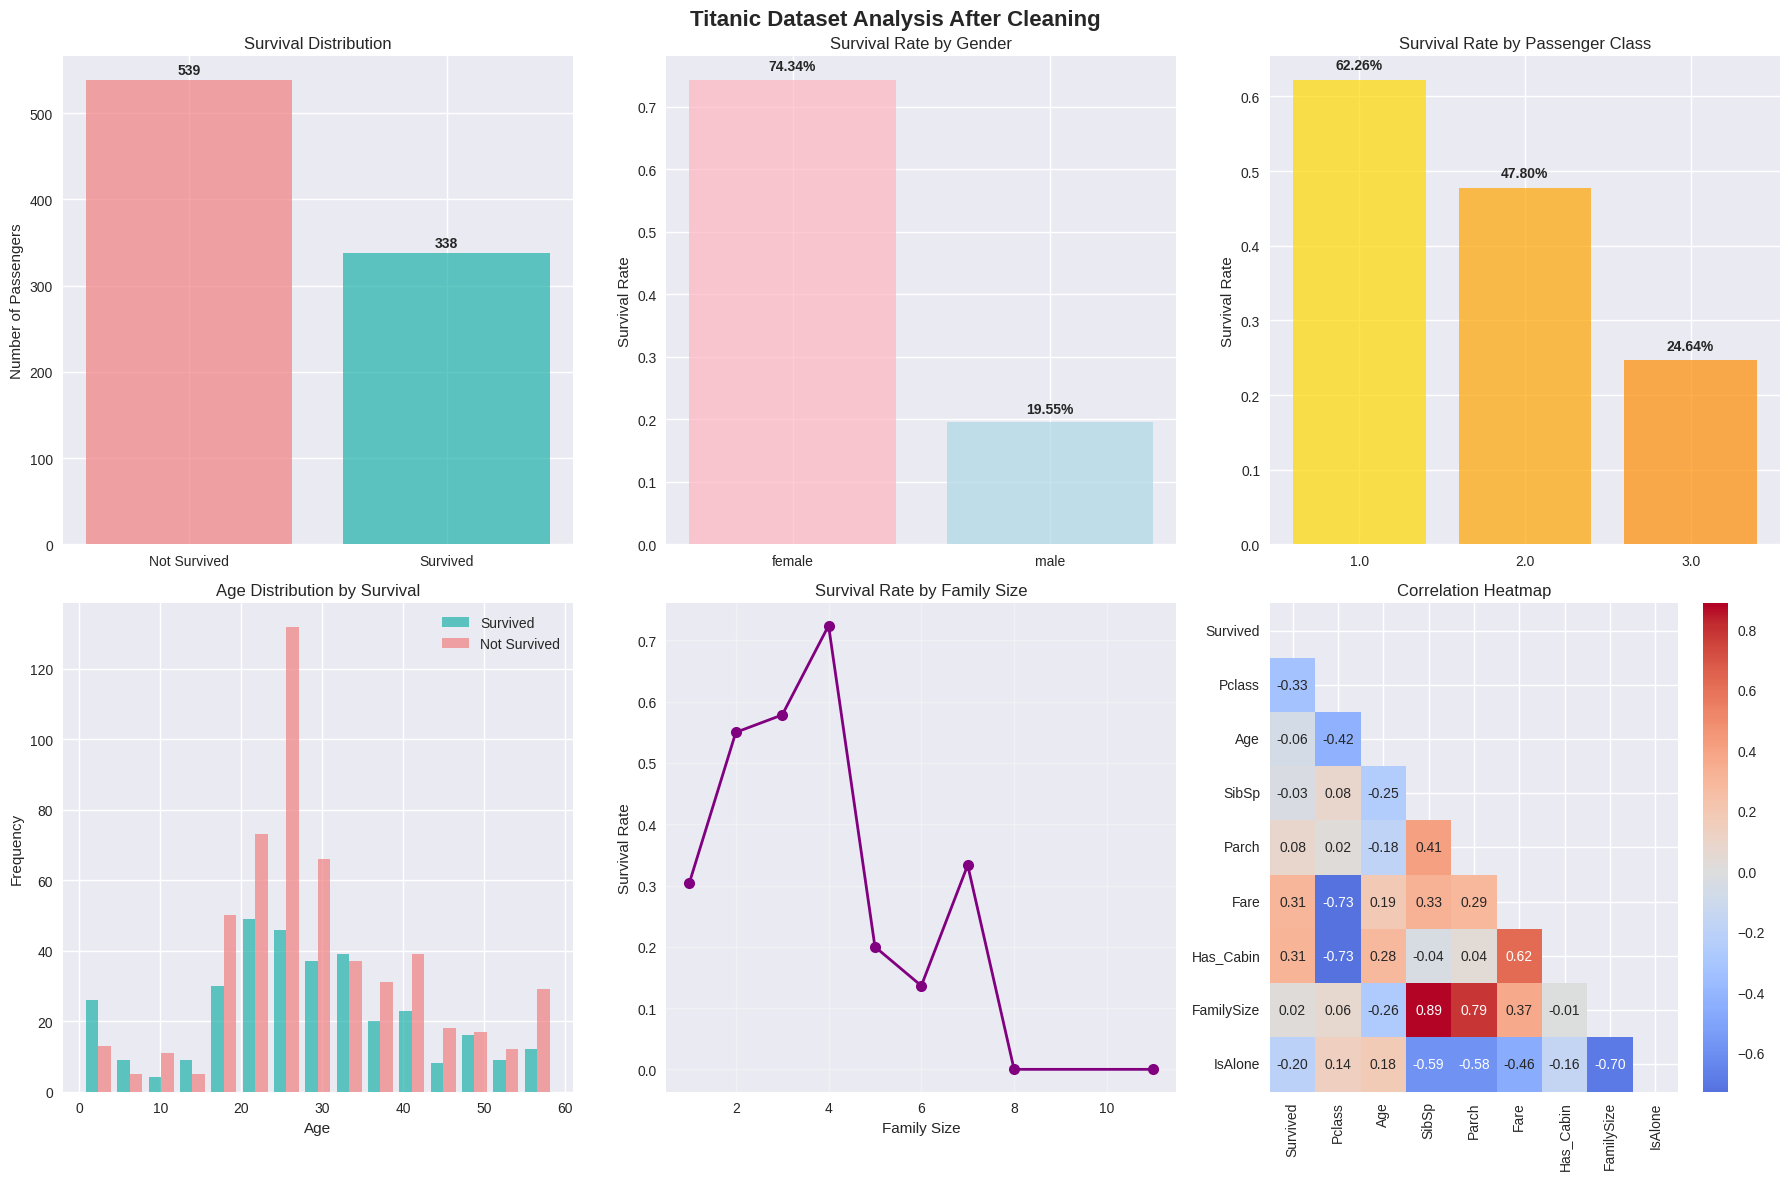

In [29]:
# Enhanced Data Visualization
print("=== ENHANCED DATA VISUALIZATION ===")

# Set up the plotting style
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Titanic Dataset Analysis After Cleaning', fontsize=16, fontweight='bold')

# 1. Survival distribution
survival_counts = df_cleaned['Survived'].value_counts()
axes[0,0].bar(['Not Survived', 'Survived'], survival_counts.values,
              color=['lightcoral', 'lightseagreen'], alpha=0.7)
axes[0,0].set_title('Survival Distribution')
axes[0,0].set_ylabel('Number of Passengers')
for i, v in enumerate(survival_counts.values):
    axes[0,0].text(i, v + 3, str(v), ha='center', va='bottom', fontweight='bold')

# 2. Survival rate by gender
gender_survival = df_cleaned.groupby('Sex')['Survived'].mean()
axes[0,1].bar(gender_survival.index, gender_survival.values,
              color=['lightpink', 'lightblue'], alpha=0.7)
axes[0,1].set_title('Survival Rate by Gender')
axes[0,1].set_ylabel('Survival Rate')
for i, v in enumerate(gender_survival.values):
    axes[0,1].text(i, v + 0.01, f'{v:.2%}', ha='center', va='bottom', fontweight='bold')

# 3. Survival rate by Pclass
pclass_survival = df_cleaned.groupby('Pclass')['Survived'].mean()
axes[0,2].bar(pclass_survival.index.astype(str), pclass_survival.values,
              color=['gold', 'orange', 'darkorange'], alpha=0.7)
axes[0,2].set_title('Survival Rate by Passenger Class')
axes[0,2].set_ylabel('Survival Rate')
for i, v in enumerate(pclass_survival.values):
    axes[0,2].text(i, v + 0.01, f'{v:.2%}', ha='center', va='bottom', fontweight='bold')

# 4. Age distribution by survival
survived_age = df_cleaned[df_cleaned['Survived'] == 1]['Age']
not_survived_age = df_cleaned[df_cleaned['Survived'] == 0]['Age']
axes[1,0].hist([survived_age, not_survived_age],
               bins=15, alpha=0.7, label=['Survived', 'Not Survived'],
               color=['lightseagreen', 'lightcoral'])
axes[1,0].set_title('Age Distribution by Survival')
axes[1,0].set_xlabel('Age')
axes[1,0].set_ylabel('Frequency')
axes[1,0].legend()

# 5. Survival rate by family size
family_survival = df_cleaned.groupby('FamilySize')['Survived'].mean()
axes[1,1].plot(family_survival.index, family_survival.values,
               marker='o', linewidth=2, markersize=8, color='purple')
axes[1,1].set_title('Survival Rate by Family Size')
axes[1,1].set_xlabel('Family Size')
axes[1,1].set_ylabel('Survival Rate')
axes[1,1].grid(True, alpha=0.3)

# 6. Correlation heatmap (only numerical columns)
numerical_cols = df_cleaned.select_dtypes(include=[np.number]).columns
corr_matrix = df_cleaned[numerical_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm',
            center=0, ax=axes[1,2], fmt='.2f')
axes[1,2].set_title('Correlation Heatmap')

plt.tight_layout()
plt.show()

In [30]:
# Prepare data for machine learning
print("=== PREPARING DATA FOR MACHINE LEARNING ===")

# Separate features and target
X = df_cleaned.drop('Survived', axis=1)
y = df_cleaned['Survived']

print("Features shape:", X.shape)
print("Target shape:", y.shape)

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print(f"\nCategorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

# One-hot encoding for categorical variables
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print(f"\nShape after encoding: {X_encoded.shape}")
print("Encoded features:")
print(X_encoded.columns.tolist())

=== PREPARING DATA FOR MACHINE LEARNING ===
Features shape: (877, 13)
Target shape: (877,)

Categorical columns: ['Sex', 'Embarked', 'Title', 'AgeGroup', 'FareGroup']
Numerical columns: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Has_Cabin', 'FamilySize', 'IsAlone']

Shape after encoding: (877, 22)
Encoded features:
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Has_Cabin', 'FamilySize', 'IsAlone', 'Sex_male', 'Embarked_Q', 'Embarked_S', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare', 'AgeGroup_Teen', 'AgeGroup_Adult', 'AgeGroup_Middle', 'AgeGroup_Senior', 'FareGroup_Medium', 'FareGroup_High', 'FareGroup_Very High']


In [31]:
# Feature scaling and train-test split
print("=== FEATURE SCALING AND DATA SPLITTING ===")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Training survival rate: {y_train.mean():.2%}")
print(f"Test survival rate: {y_test.mean():.2%}")

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Scale only numerical columns (excluding binary columns)
cols_to_scale = [col for col in numerical_cols if col in X_train.columns]
X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

print(f"\nScaled {len(cols_to_scale)} numerical columns")

=== FEATURE SCALING AND DATA SPLITTING ===
Training set size: 701
Test set size: 176
Training survival rate: 38.52%
Test survival rate: 38.64%

Scaled 8 numerical columns


In [36]:
# Convert categorical columns to numeric
X = pd.get_dummies(X, drop_first=True)


In [38]:
# Fill numeric NaN
X = X.fillna(X.mean())

# If categorical still exist:
X = X.fillna(X.mode().iloc[0])


In [39]:
# ============================
# Build and evaluate a simple model
# ============================

# Imports
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

# 1. Convert categorical to numeric
X = pd.get_dummies(X, drop_first=True)

# 2. Handle missing values
X = X.fillna(X.mean())   # For numeric columns

# 3. Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4. Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("=== MODEL TRAINING AND EVALUATION ===")

# 5. Train KNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# 6. Make predictions
y_pred = knn.predict(X_test_scaled)
y_pred_proba = knn.predict_proba(X_test_scaled)[:, 1]

# 7. Evaluate
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"KNN Classifier Accuracy: {accuracy:.4f}")
print(f"\nConfusion Matrix:\n{conf_matrix}")
print(f"\nClassification Report:\n{class_report}")


=== MODEL TRAINING AND EVALUATION ===
KNN Classifier Accuracy: 0.7898

Confusion Matrix:
[[84 17]
 [20 55]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       101
           1       0.76      0.73      0.75        75

    accuracy                           0.79       176
   macro avg       0.79      0.78      0.78       176
weighted avg       0.79      0.79      0.79       176



=== ENHANCED MODEL EVALUATION ===


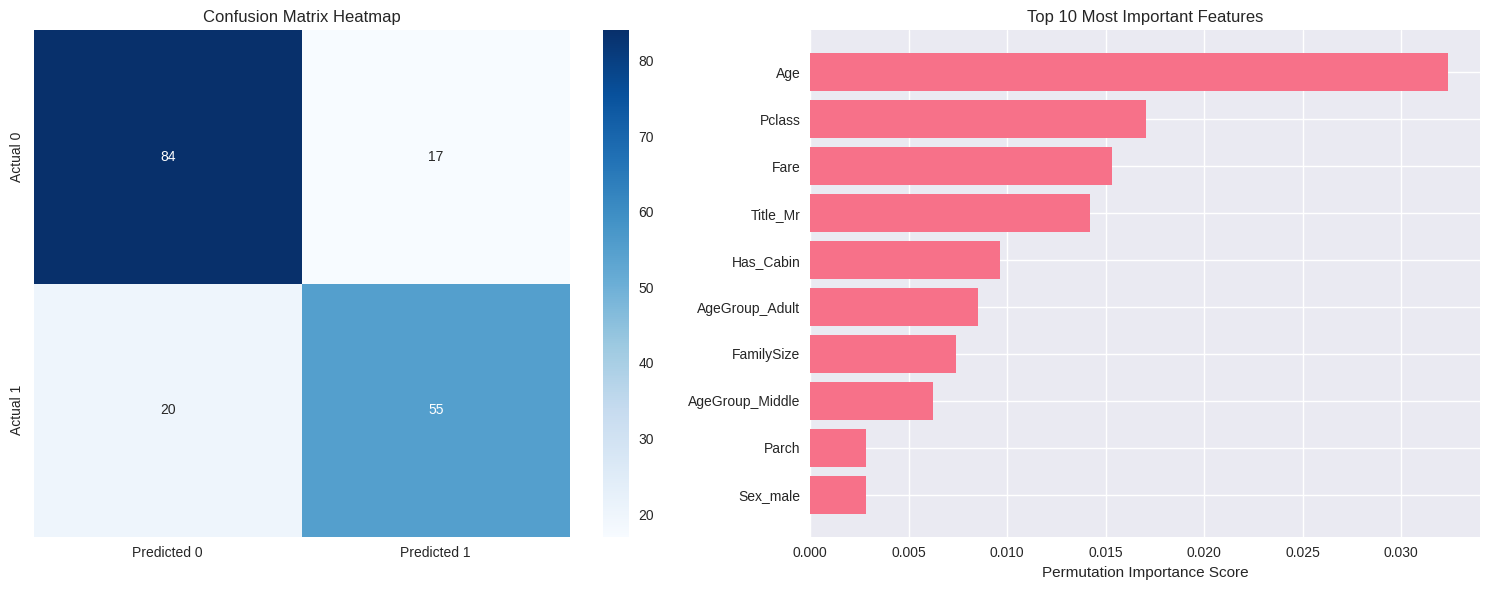

In [41]:
# Enhanced model evaluation visualization
print("=== ENHANCED MODEL EVALUATION ===")

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
import pandas as pd

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# ============================
# Confusion Matrix Heatmap
# ============================
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Predicted 0', 'Predicted 1'],
    yticklabels=['Actual 0', 'Actual 1'],
    ax=axes[0]
)
axes[0].set_title('Confusion Matrix Heatmap')

# ============================
# Feature Importance (Permutation Importance)
# ============================

# Compute permutation importance on the test set
perm_importance = permutation_importance(
    knn,
    X_test_scaled,
    y_test,
    n_repeats=10,
    random_state=42
)

# Use original column names from X_train
feature_names = X_train.columns

# Build DataFrame
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': perm_importance.importances_mean
}).sort_values('importance', ascending=True).tail(10)

# Plot top 10 important features
axes[1].barh(
    feature_importance['feature'],
    feature_importance['importance']
)
axes[1].set_xlabel('Permutation Importance Score')
axes[1].set_title('Top 10 Most Important Features')

plt.tight_layout()
plt.show()


In [43]:
# =======================================
# Final data summary and saving
# =======================================
print("=== FINAL DATA SUMMARY ===")

print(f"Original dataset shape: {df.shape}")
print(f"Cleaned dataset shape: {df_cleaned.shape}")
print(f"Data retention: {len(df_cleaned)/len(df):.2%}")

print("\nFinal data types:")
print(df_cleaned.dtypes)

print("\nMissing values in cleaned data:")
print(df_cleaned.isnull().sum())

# ---------------------------------------
# Save cleaned dataset
# ---------------------------------------
df_cleaned.to_csv("titanic_cleaned_enhanced.csv", index=False)
print("\nCleaned dataset saved as 'titanic_cleaned_enhanced.csv'")


# ---------------------------------------
# CONVERT SCALED ARRAYS TO DATAFRAMES
# ---------------------------------------
X_train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_df  = pd.DataFrame(X_test_scaled, columns=X_test.columns)
y_train_df = pd.DataFrame(y_train, columns=["Survived"])
y_test_df  = pd.DataFrame(y_test,  columns=["Survived"])

# ---------------------------------------
# Save processed training and test sets
# ---------------------------------------
X_train_df.to_csv("titanic_X_train.csv", index=False)
X_test_df.to_csv("titanic_X_test.csv", index=False)
y_train_df.to_csv("titanic_y_train.csv", index=False)
y_test_df.to_csv("titanic_y_test.csv", index=False)

print("Processed training and test sets saved")


=== FINAL DATA SUMMARY ===
Original dataset shape: (909, 12)
Cleaned dataset shape: (877, 14)
Data retention: 96.48%

Final data types:
Survived         int64
Pclass         float64
Sex             object
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Embarked        object
Has_Cabin        int64
FamilySize       int64
IsAlone          int64
Title           object
AgeGroup      category
FareGroup     category
dtype: object

Missing values in cleaned data:
Survived      0
Pclass        0
Sex           0
Age           2
SibSp         0
Parch         0
Fare          0
Embarked      0
Has_Cabin     0
FamilySize    0
IsAlone       0
Title         0
AgeGroup      2
FareGroup     0
dtype: int64

Cleaned dataset saved as 'titanic_cleaned_enhanced.csv'
Processed training and test sets saved


In [44]:
# Additional insights and recommendations
print("=== ADDITIONAL INSIGHTS AND RECOMMENDATIONS ===")

# Survival insights
survival_by_class_sex = df_cleaned.groupby(['Pclass', 'Sex'])['Survived'].mean().unstack()
print("\nSurvival rates by Class and Gender:")
display(survival_by_class_sex)

# Age insights
print(f"\nAverage age by survival:")
print(df_cleaned.groupby('Survived')['Age'].mean())

# Fare insights
print(f"\nAverage fare by survival:")
print(df_cleaned.groupby('Survived')['Fare'].mean())

# Family insights
print(f"\nAverage family size by survival:")
print(df_cleaned.groupby('Survived')['FamilySize'].mean())

print("\n=== RECOMMENDATIONS FOR FURTHER IMPROVEMENT ===")
print("1. Try different classification algorithms (Random Forest, SVM, XGBoost)")
print("2. Perform hyperparameter tuning for better model performance")
print("3. Consider feature selection to reduce dimensionality")
print("4. Experiment with different encoding strategies for categorical variables")
print("5. Use cross-validation for more robust performance estimation")

=== ADDITIONAL INSIGHTS AND RECOMMENDATIONS ===

Survival rates by Class and Gender:


Sex,female,male
Pclass,,
1.0,0.944444,0.385246
2.0,0.896104,0.171429
3.0,0.525547,0.135838



Average age by survival:
Survived
0    29.491636
1    27.870178
Name: Age, dtype: float64

Average fare by survival:
Survived
0    18.849328
1    31.617691
Name: Fare, dtype: float64

Average family size by survival:
Survived
0    1.881262
1    1.946746
Name: FamilySize, dtype: float64

=== RECOMMENDATIONS FOR FURTHER IMPROVEMENT ===
1. Try different classification algorithms (Random Forest, SVM, XGBoost)
2. Perform hyperparameter tuning for better model performance
3. Consider feature selection to reduce dimensionality
4. Experiment with different encoding strategies for categorical variables
5. Use cross-validation for more robust performance estimation
